# 3-Qubit phase flip Quantum Error Correction Code

This notebook demonstrates the 3-Qubit phase flip Quantum Error Correction Code from Chapter 13, Quantum Error Correction: A Primer.

[![Open In Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Polaris-QCI/Quantum-Computing-and-Information-ed2/main?labpath=Qiskit%2F13-Quantum-Error-Correction%2F3-qubit-phaseflip-demo.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Polaris-QCI/Quantum-Computing-and-Information-ed2/blob/main/Qiskit/13-Quantum-Error-Correction/3-qubit-phaseflip-demo.ipynb)

## 0. Setup

The cells below install the packages and import the libraries needed by this demo.

In [ ]:
#@title Install Qiskit and other dependencies
%pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc

In [2]:
# Imports

from math import cos, sin, pi as π
from ipywidgets import interact
from IPython.display import display, Markdown
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit import AncillaRegister, ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import partial_trace, Statevector

## 1. Circuit Definition

The following cell defines the 3-Qubit Phase Flip Quantum Error Correction Code circuit.

Refer to **2. Interaction** for configurable options (parameters).

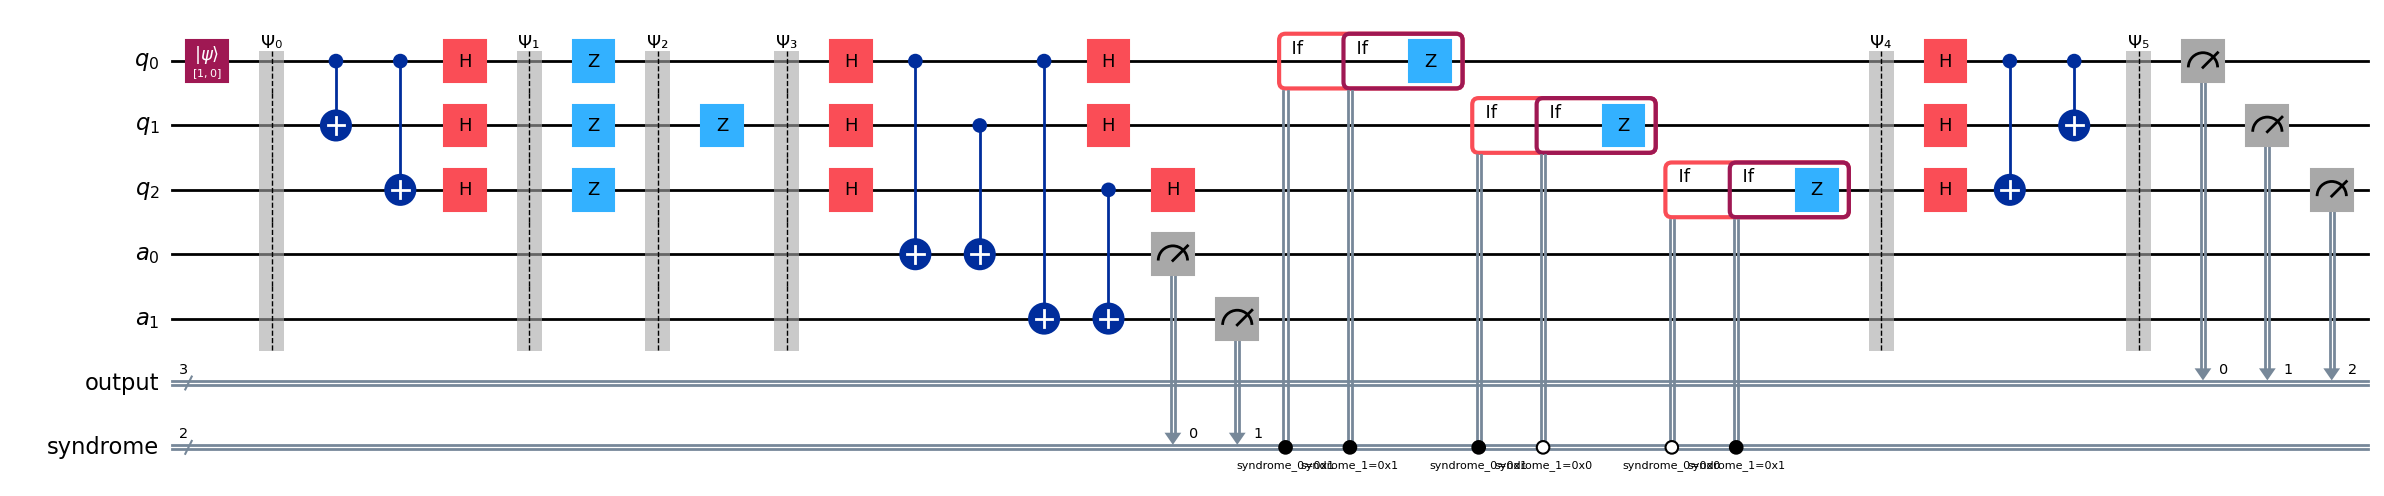

In [3]:
def create_state(θ, φ):
    α = cos(θ/2)
    β = sin(θ/2) * (cos(φ) + 1j * sin(φ)) # exp(iφ) sin(θ/2)
    return Statevector([α, β])


def create_circuit(initial_state = create_state(0, 0), unitary_op = None, error_bit = -1):
    q = [q1, q2, q3] = QuantumRegister(3, name='q')
    a = [a1, a2] = AncillaRegister(2, name='a')
    o = ClassicalRegister(3, name='output')
    s = [s1, s2] = ClassicalRegister(2, name='syndrome')
    circuit = QuantumCircuit(q, a, o, s)
    circuit.initialize(initial_state, q1)
    circuit.save_statevector(label = "Ψ₀")
    circuit.cx(q1, q2)
    circuit.cx(q1, q3)
    circuit.h(q)
    circuit.save_statevector(label = 'Ψ₁')
    if unitary_op == 'X':
        circuit.z(q)
    circuit.save_statevector(label='Ψ₂')
    if error_bit != -1:
        circuit.z(q[error_bit])
    circuit.save_statevector(label='Ψ₃')
    circuit.h(q)
    circuit.cx(q1, a1)
    circuit.cx(q2, a1)
    circuit.cx(q1, a2)
    circuit.cx(q3, a2)
    circuit.h(q)
    circuit.measure(a, s)
    with circuit.if_test((s1, 1)):
        with circuit.if_test((s2, 1)):
            circuit.z(q1)
    with circuit.if_test((s1, 1)):
        with circuit.if_test((s2, 0)):
            circuit.z(q2)
    with circuit.if_test((s1, 0)):
        with circuit.if_test((s2, 1)):
            circuit.z(q3)
    circuit.save_statevector(label='Ψ₄')
    circuit.h(q)
    circuit.cx(q1, q3)
    circuit.cx(q1, q2)
    circuit.save_statevector(label='Ψ₅')
    circuit.measure(q, o)
    return circuit


def show_circuit(unitary_op, error_bit):
    circuit = create_circuit(unitary_op = unitary_op, error_bit = error_bit)
    display(circuit.draw('mpl', fold = -1))


# interact(show_circuit, unitary_op = ['None', 'X'], error_bit = [-1, 0, 1, 2])
show_circuit('X', 1)

## 2. Interaction

The cell below displays and runs variants of the circuit for the 3-Qubit Phase Flip Quantum Error Correction Code defined in **1. Circuit Definition**, and shows the state vector resulting at each stage of the computation.

You can experiment with $\theta$ and $\phi$ to create a general input state
$$
|\psi\rangle = \cos\frac{\theta}{2}|0\rangle + e^{i\phi}\sin\frac{\theta}{2}|1\rangle
$$
and observe the execution of the circuit.

Some examples are:

| State | $\theta$ | $\phi$ |
|-------|----------|--------|
| $\|0\rangle$ | 0 | 0 |
| $\|1\rangle$ | $\pi$ | 0 |
| $\frac{1}{\sqrt{2}}(\|0\rangle + i\|1\rangle)$ | $\frac{\pi}{2}$ | $\frac{\pi}{2}$ |

You can also experiment with these parameters:

* `unitary_op`: Optionally apply a logical unitary operation $X_L$ to the input state. 
* `error_op`: Single qubit to apply a phase flip (Z) error to: -1 = no error, 0-2 = error on qubit 0-2.

In the statevector calculations below, the statevector for a single qubit is obtained from the system state by tracing out the other qubits.
This is a way to ``factorize'' a product state $|a\rangle\otimes|b\rangle$ into its parts $|a\rangle$ and $|b\rangle$. 
However, product states do not have unique facorizations, because $|a\rangle\otimes|b\rangle = e^{i\theta}|a\rangle\otimes e^{-i\theta}|b\rangle$ for any real $\theta$.
So, in some cases the statevector shown below may be different from the expected one by a global phase factor.

In [4]:
# Basis state |0⟩
# θ = 0
# φ = 0

# Basis state |1⟩
θ = π
φ = 0

# Another state: 1/√2 (|0⟩ + i|1⟩)
# θ = π/2
# φ = π/2

# Unitary operation: X (optional)
# unitary_op = None
unitary_op = 'X'

# Error bit: -1 is no error, otherwise error on qubit 0, 1, or 2
error_bit = 1

circuit = create_circuit(create_state(θ, φ), unitary_op = unitary_op, error_bit = error_bit)
simulator = AerSimulator()
result = simulator.run(circuit).result()
statevectors = result.data(0)
Ψ0 = statevectors["Ψ₀"]
input = partial_trace(Ψ0, [1, 2, 3, 4]).to_statevector() # extract the state of just the input qubit (q0)
Ψ1 = statevectors["Ψ₁"]
Ψ2 = statevectors["Ψ₂"]
Ψ3 = statevectors["Ψ₃"]
Ψ4 = statevectors["Ψ₄"]
Ψ5 = statevectors["Ψ₅"]
output = partial_trace(Ψ5, [1, 2, 3, 4]).to_statevector() # extract the state of just the output qubit (q0)


def fmt_sv(statevector):
    return statevector.draw('latex_source').replace('|', r'\|') # escape | for use in Markdown table


display(Markdown(f"""Stage | State
---    | ---
Input  | ${fmt_sv(input)}$ (up to a phase difference)
Ψ₀     | ${fmt_sv(Ψ0)}$
Ψ₁     | ${fmt_sv(Ψ1)}$
Ψ₂     | ${fmt_sv(Ψ2)}$
Ψ₃     | ${fmt_sv(Ψ3)}$
Ψ₄     | ${fmt_sv(Ψ4)}$
Ψ₅     | ${fmt_sv(Ψ5)}$
Output | ${fmt_sv(output)}$ (up to a phase difference)
"""))

sampler = Sampler(simulator)
job = sampler.run([circuit], shots=1000)
result = job.result()

output_counts = result[0].data.output.get_counts()
counts_table = """Output bit | Count
--- | ---
"""
for bits, val in sorted(output_counts.items()):
    assert bits[0:2] == "00"
    bit = bits[2]
    counts_table += f"{bit}|{val}\n"

display(Markdown(counts_table))
syndrome_counts = result[0].data.syndrome.get_counts()
assert len(syndrome_counts) == 1
syndrome = next(iter(syndrome_counts.keys()))
display(Markdown(f"Syndrome (from the leftmost two qubits in Ψ₅) = {syndrome}"))

Stage | State
---    | ---
Input  | $ \|1\rangle$
Ψ₀     | $ \|00001\rangle$
Ψ₁     | $\frac{\sqrt{2}}{4} \|00000\rangle- \frac{\sqrt{2}}{4} \|00001\rangle- \frac{\sqrt{2}}{4} \|00010\rangle+\frac{\sqrt{2}}{4} \|00011\rangle- \frac{\sqrt{2}}{4} \|00100\rangle+\frac{\sqrt{2}}{4} \|00101\rangle+\frac{\sqrt{2}}{4} \|00110\rangle- \frac{\sqrt{2}}{4} \|00111\rangle$
Ψ₂     | $\frac{\sqrt{2}}{4} \|00000\rangle+\frac{\sqrt{2}}{4} \|00001\rangle+\frac{\sqrt{2}}{4} \|00010\rangle+\frac{\sqrt{2}}{4} \|00011\rangle+\frac{\sqrt{2}}{4} \|00100\rangle+\frac{\sqrt{2}}{4} \|00101\rangle+\frac{\sqrt{2}}{4} \|00110\rangle+\frac{\sqrt{2}}{4} \|00111\rangle$
Ψ₃     | $\frac{\sqrt{2}}{4} \|00000\rangle+\frac{\sqrt{2}}{4} \|00001\rangle- \frac{\sqrt{2}}{4} \|00010\rangle- \frac{\sqrt{2}}{4} \|00011\rangle+\frac{\sqrt{2}}{4} \|00100\rangle+\frac{\sqrt{2}}{4} \|00101\rangle- \frac{\sqrt{2}}{4} \|00110\rangle- \frac{\sqrt{2}}{4} \|00111\rangle$
Ψ₄     | $\frac{\sqrt{2}}{4} \|01000\rangle+\frac{\sqrt{2}}{4} \|01001\rangle+\frac{\sqrt{2}}{4} \|01010\rangle+\frac{\sqrt{2}}{4} \|01011\rangle+\frac{\sqrt{2}}{4} \|01100\rangle+\frac{\sqrt{2}}{4} \|01101\rangle+\frac{\sqrt{2}}{4} \|01110\rangle+\frac{\sqrt{2}}{4} \|01111\rangle$
Ψ₅     | $ \|01000\rangle$
Output | $ \|0\rangle$


Output bit | Count
--- | ---
0|1000


Syndrome (from the leftmost two qubits in Ψ₅) = 01